In [1]:
import cv2,os

data_path='samples'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'Covid Negative': 0, 'Covid Positive': 1}
['Covid Negative', 'Covid Positive']
[0, 1]


In [2]:
#img_size=100 or 240
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)       # converting image to grayscale    
      
            resized=cv2.resize(gray,(150,150))             # resizing the grayscale into 600x1300
           
            data.append(resized)
            target.append(label_dict[category])
            
        except Exception as e:
            print('Exception:',e)
            

In [3]:
import numpy as np

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],150,150,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [4]:
np.save('data',data)
np.save('target',new_target)

In [5]:
import numpy as np

data=np.load('data.npy')
target=np.load('target.npy')

In [6]:

from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.utils import normalize
from keras.layers import Concatenate
from keras import Input
from keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:]   
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):

    conv = Conv2D(128, parrallel_kernels[k],padding='same',activation='relu',input_shape=input_shape,strides=1)(inp)
    convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inputs=inp, outputs=out)

model = Sequential()
model.add(conv_model)

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 150, 150, 384)     11008     
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      221248    
                                                                 
 activation (Activation)     (None, 148, 148, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                        

In [7]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.2)

In [8]:
#test_data


In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

history=model.fit(train_data,train_target,epochs=25,callbacks=[checkpoint],validation_split=0.1)


Epoch 1/25
7/7 [==============================] - 64s 9s/step - loss: 0.7052 - accuracy: 0.5346 - val_loss: 0.5657 - val_accuracy: 0.7200
Epoch 2/25
7/7 [==============================] - 72s 11s/step - loss: 0.7196 - accuracy: 0.5899 - val_loss: 0.6250 - val_accuracy: 0.7200
Epoch 3/25
7/7 [==============================] - 53s 8s/step - loss: 0.6803 - accuracy: 0.6037 - val_loss: 0.6542 - val_accuracy: 0.7200
Epoch 4/25
7/7 [==============================] - 54s 8s/step - loss: 0.6649 - accuracy: 0.6452 - val_loss: 0.5717 - val_accuracy: 0.7200
Epoch 5/25
7/7 [==============================] - 54s 8s/step - loss: 0.6408 - accuracy: 0.6590 - val_loss: 0.5858 - val_accuracy: 0.8800
Epoch 6/25
7/7 [==============================] - 58s 8s/step - loss: 0.5975 - accuracy: 0.7143 - val_loss: 0.4048 - val_accuracy: 0.8800
Epoch 7/25
7/7 [==============================] - 61s 9s/step - loss: 0.5348 - accuracy: 0.7880 - val_loss: 0.3518 - val_accuracy: 0.9200
Epoch 8/25
7/7 [=================

In [10]:
#from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
bs=8
print("Evaluating...")
pred=model.predict(test_data,batch_size=bs)
#print(pred)
pred=np.argmax(pred,axis=1)
#print(pred)

print(classification_report(test_target.argmax(axis=1),pred))

cm=confusion_matrix(test_target.argmax(axis=1),pred)
total=sum(sum(cm))
acc=(cm[0,0]+cm[1,1])/total
#print(cm)
print("accuracy:",acc)


Evaluating...
              precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.80      0.88      0.84        41

    accuracy                           0.77        61
   macro avg       0.74      0.71      0.72        61
weighted avg       0.76      0.77      0.76        61

accuracy: 0.7704918032786885


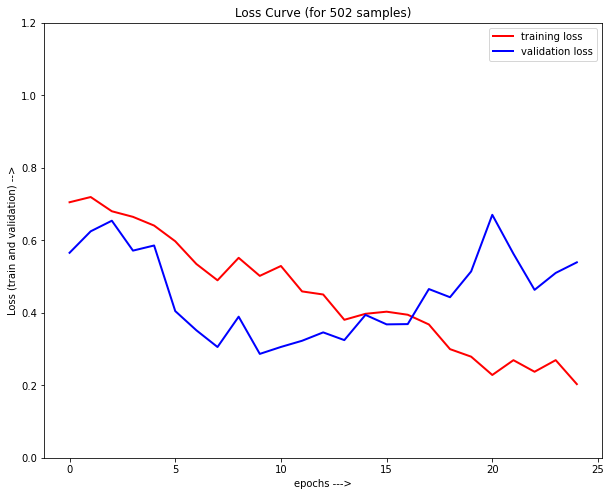

In [12]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,8))
plt.plot(history.history['loss'],'r',linewidth=2,label='training loss')
plt.plot(history.history['val_loss'],'b',linewidth=2,label='validation loss')
plt.xlabel('epochs --->')
plt.ylabel('Loss (train and validation) -->')
plt.title('Loss Curve (for 502 samples)')
plt.ylim(0,1.2)
#plt.xlim(0,25)
plt.legend()
#plt.show()

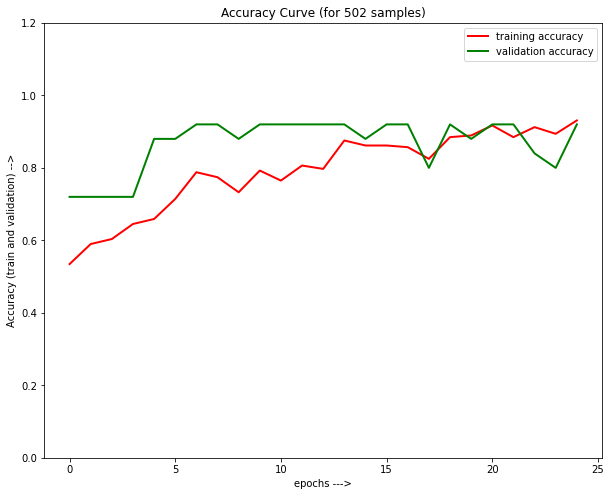

In [13]:
plt.figure(figsize=(10,8))

plt.plot(history.history['accuracy'],'r',linewidth=2,label='training accuracy')
plt.plot(history.history['val_accuracy'],'g',linewidth=2,label='validation accuracy')
plt.xlabel('epochs --->')
plt.ylabel('Accuracy (train and validation) -->')
plt.title('Accuracy Curve (for 502 samples)')
plt.ylim(0,1.2)
plt.legend()
#plt.show()


In [14]:
print(model.evaluate(test_data,test_target))

2/2 [==============================] - 3s 1s/step - loss: 1.0485 - accuracy: 0.7705
[1.0485138893127441, 0.7704917788505554]


In [24]:
pip install virtualenv

  Attempting uninstall: filelock
    Found existing installation: filelock 3.0.12
    Uninstalling filelock-3.0.12:
      Successfully uninstalled filelock-3.0.12

